<div class="alert alert-block alert-info" align="center">
    <h1>
        Imports
    </h1>
</div>

In [1]:
import numpy as np
import pandas as pd
import mnist
from keras.datasets import fashion_mnist

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.legend_handler import HandlerLine2D
from keras.utils import to_categorical

Using TensorFlow backend.


<div class="alert alert-block alert-info" align="center">
    <h1>
        Déclarations
    </h1>
</div>

<div align="center"><h1> Fonctions utiles </h1></div>

In [2]:
def plot_histories (eta, epochs, cost_history, accuracy_history):
    fig, ax = plt.subplots(figsize = (5, 5))
    ax.set_ylabel(r'$J(\theta)$')
    ax.set_xlabel('Epochs')
    ax.set_title(r"$\eta$ :{}".format(eta))
    line1, = ax.plot(range(epochs), cost_history, label = 'Cost')
    line2, = ax.plot(range(epochs), accuracy_history, label = 'Accuracy')
    plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 4)})



<div align="center"><h1> Classes </h1></div>

In [3]:
class Conv3x3:
    # A Convolution layer using 3x3 filters.

    def __init__(self, num_filters):
        self.num_filters = num_filters
        
        #print ("Creation d'un Conv3x3 avec ", num_filters)
        # filters is a 3d array with dimensions (num_filters, 3, 3)
        # We divide by 9 to reduce the variance of our initial values
        self.filters = np.random.randn(num_filters, 3, 3) / 9

    def iterate_regions(self, image):
        '''
        Generates all possible 3x3 image regions using valid padding.
        - image is a 2d numpy array
        '''
        h, w = image.shape

        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3)]
                yield im_region, i, j

    def forward(self, input):
        '''
        Performs a forward pass of the conv layer using the given input.
        Returns a 3d numpy array with dimensions (h, w, num_filters).
        - input is a 2d numpy array
        '''
        #on doit faire ne sorte que l'entrée soit un tableau 3D non 2d
        #print ("Je suis dans le forward de Conv3x3")
        self.last_input = input
        
        h, w = input.shape
        
        output = np.zeros((h - 2, w - 2, self.num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

        return output
    
    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the conv layer.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        d_L_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
          for f in range(self.num_filters):
            d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

        # Update filters
        self.filters -= learn_rate * d_L_d_filters

        # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
        # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
        # other layer in our CNN.
        return None
        
    
    

class MaxPool2:
    # A Max Pooling layer using a pool size of 2.

    def iterate_regions(self, image):
        '''
        Generates non-overlapping 2x2 image regions to pool over.
        - image is a 2d numpy array
        '''
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, input):
        '''
        Performs a forward pass of the maxpool layer using the given input.
        Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
        - input is a 3d numpy array with dimensions (h, w, num_filters)
        '''
        #print ("je suis dans le forward de MaxPool2")
        self.last_input = input
        h, w, num_filters = input.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output
    
    def backprop(self, d_L_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
    '''
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
          h, w, f = im_region.shape
          amax = np.amax(im_region, axis=(0, 1))

          for i2 in range(h):
            for j2 in range(w):
              for f2 in range(f):
                # If this pixel was the max value, copy the gradient to it.
                if im_region[i2, j2, f2] == amax[f2]:
                  d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input
    
class MyFlatten: # A Flattening layer
    def forward(self, input):
        #print(f'input : {input.shape}')
        #print(f'output : {input.flatten().shape}')
        self.last_input_shape = input.shape
        input = input.flatten()
        self.last_input = input
        return input
    def backprop(self, d_L_d_out):
        return d_L_d_out.reshape(self.last_input_shape)
    
    
class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the softmax layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float
    '''
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b
      return d_L_d_inputs.reshape(self.last_input_shape)    
    


class MyCNN:
    def __init__(self):
        self.nbLayers = 0
        self.layers = [] # NN layers

    def printLayers(self):
        for i in range(len(self.CNN)):
            print(self.CNN[i].activationCNNFunc)
        for i in range(len(self.layers)):
            print(self.layers[i].activation_func)
        
    def info(self):
        print(f'Content of the network :');
        j = 0;
        for i in range(len(self.CNN)):
            print(f'\n\tLayer n° {i} du CNN => ')
            print(f'\t\tInput : {self.CNN[i].input}\n\t\tOutput : {self.CNN[i].output}')
            if (i != 0):
                print(f'\t\tCouche : {self.CNN[i].activationCNNFunc}')
                print(f'\t\tW shape : {self.CNN[i].parameters["W"].shape}\n')
                #t\tW data :\n{self.CNN[i].parameters["W"]}')
                print(f'\t\tb shape : {self.CNN[i].parameters["b"].shape}\n')
                #\t\tb data :\n{self.CNN[i].parameters["b"]}')
                
        for i in range(len(self.layers)):
            print(f'\n\tLayer n° {i} du NN => ')
            print(f'\t\tInput : {self.layers[i].input}\n\t\tOutput : {self.layers[i].output}')
            if (i != 0):
                print(f'\t\tCouche : {self.layers[i].activation_func}')
                print(f'\t\tW shape : {self.layers[i].parameters["W"].shape}\n')
                #\t\tW data :\n{self.layers[i].parameters["W"]}')
                print(f'\t\tb shape : {self.layers[i].parameters["b"].shape}\n')
                #\t\tb data :\n{self.layers[i].parameters["b"]}')

    def addLayer(self, layer):
        self.nbLayers += 1 # Le layer 0 = input, si CNN = images
        #print ("layer = ",type(self.layers))
        self.layers.append(layer)
        
     
    def forward_propagation(self, X):
        outPrevious=0
        for num_layer in range (0, self.nbLayers):
            #print ("\nPredict: lecture objet",self.layers[num_layer])
            if (type(self.layers[num_layer]) is Conv3x3):
                if num_layer==0:
                    X=(X / 255) - 0.5
                    outPrevious=self.layers[num_layer].forward(X)
                else : 
                    outPrevious=self.layers[num_layer].forward(outPrevious)
                #print ("\tpasse dans Conv3x3 - taille en sortie",outPrevious.shape)
            if (type(self.layers[num_layer]) is MaxPool2):
                outPrevious=self.layers[num_layer].forward(outPrevious)
                #print ("\tpasse dans MaxPool2 - taille en sortie",outPrevious.shape)
            if (type(self.layers[num_layer]) is MyFlatten):
                outPrevious=self.layers[num_layer].forward(outPrevious) 
                #print ("\tpasse dans Flatten - taille en sortie",outPrevious.shape)
            if (type(self.layers[num_layer]) is Softmax):
                #print ("\tpasse dans Softmax - taille en sortie",outPrevious.shape)
                outPrevious=self.layers[num_layer].forward(outPrevious)
        return outPrevious
               
        
        
    def cost_function(self, out,y):
        #print("cost_function", y.shape,out.shape)
        ##sortie=self.layers[self.nbLayers-1].parameters['A'].flatten()
        #print ("sortie.shape",sortie.shape)
        #return (-(y * np.log(out + 1e-8) + (1 - y) * np.log(1 - out + 1e-8))).mean()
        #return (-(y * np.log(out + 1e-8) + (1 - y) * np.log(1 - out + 1e-8))).mean()
        return (-np.log(out[y]))

    def backward_propagation(self, out,y,eta):
        previousGradient=0
        for num_layer in range (self.nbLayers-1,0,-1):
            if (type(self.layers[num_layer]) is Softmax):
                # initialisation du gradient à la fin
                gradient = np.zeros(10)
                gradient[y] = -1 / out[y]
                previousGradient = self.layers[num_layer].backprop(gradient, eta)
                #print ("backpropagation - softmax", previousGradient.shape)
            if (type(self.layers[num_layer]) is MaxPool2):
                previousGradient = self.layers[num_layer].backprop(previousGradient)
                #print ("backpropagation - pool", previousGradient.shape) 
            if (type(self.layers[num_layer]) is Conv3x3):
                #print ("backpropagation - Conv 3x3")        
                previousGradient = self.layers[num_layer].backprop(previousGradient, eta)
 
    def convert_prob_into_class(self,probs):
        probs = np.copy(probs)#pour ne pas perdre probs, i.e. y_hat
        probs[probs > 0.5] = 1
        probs[probs <= 0.5] = 0
        return probs



    def accuracy(self,out, y):
        acc = 1 if np.argmax(out) == y else 0
        return acc       

    def predict(self, X):
        outPrevious=self.forward_propagation(X)
        return outPrevious

    

    def fit(self, X, y, *args,**kwargs):    
        epochs=kwargs.get("epochs",20)
        verbose=kwargs.get("verbose",False)
        eta =kwargs.get("eta",0.01)
        cost_history = []
        accuracy_history = []
        for nb_epochs in range(epochs):
            cost_all_images=[]
            acc_all_images=[]
            cost = 0
            acc = 0
            print ("run epoch: ",nb_epochs+1)
            for i, (im, label) in enumerate(zip(X, y)):
                # Do a forward pass.
                out=self.forward_propagation(im)
                cost+=self.cost_function(out,label)
                cost_all_images.append(self.cost_function(out,label))
                acc+=self.accuracy(out, label)
                acc_all_images.append(self.accuracy(out, label))
                self.backward_propagation(out,label,eta)
                if verbose:
                    if i % 100 == 99:
                        print(
                        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                        (i + 1, cost / 100, acc)
                        )
                        cost = 0
                        acc = 0
            current_cost=np.average(cost_all_images)
            cost_history.append(current_cost)  
            current_acc=np.average(acc_all_images)
            accuracy_history.append(current_acc)
        
        return cost_history, accuracy_history

<div class="alert alert-block alert-info" align="center">
    <h1>
        Applications
    </h1>
</div>

<div align="center"><h1> Classification des données de mnist </h1></div>

## CNN Avec MNIST

Learning on: 520  examples
Test on: 280  examples
run epoch:  1
[Step 100] Past 100 steps: Average Loss 2.204 | Accuracy: 17%
[Step 200] Past 100 steps: Average Loss 2.084 | Accuracy: 40%
[Step 300] Past 100 steps: Average Loss 1.899 | Accuracy: 45%
[Step 400] Past 100 steps: Average Loss 1.725 | Accuracy: 55%
[Step 500] Past 100 steps: Average Loss 1.567 | Accuracy: 61%
run epoch:  2
[Step 100] Past 100 steps: Average Loss 1.390 | Accuracy: 65%
[Step 200] Past 100 steps: Average Loss 1.387 | Accuracy: 72%
[Step 300] Past 100 steps: Average Loss 1.320 | Accuracy: 72%
[Step 400] Past 100 steps: Average Loss 1.223 | Accuracy: 74%
[Step 500] Past 100 steps: Average Loss 1.125 | Accuracy: 76%
run epoch:  3
[Step 100] Past 100 steps: Average Loss 1.035 | Accuracy: 79%
[Step 200] Past 100 steps: Average Loss 1.053 | Accuracy: 81%
[Step 300] Past 100 steps: Average Loss 1.035 | Accuracy: 75%
[Step 400] Past 100 steps: Average Loss 0.973 | Accuracy: 79%
[Step 500] Past 100 steps: Average Loss 

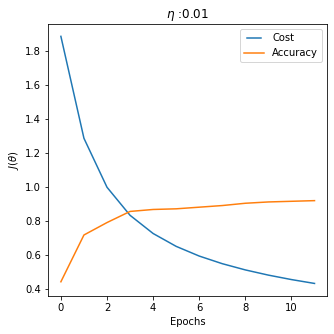

In [4]:

test_images = mnist.test_images()[:800]
test_labels = mnist.test_labels()[:800]


# Jeu d'apprentissage 60%
validation_size = 0.65

# 40% du jeu de données pour le test
testsize = 1 - validation_size

seed = 30

# séparation jeu d'apprentissage et jeu de test
X_train, X_test, y_train, y_test = train_test_split(test_images, test_labels, train_size = validation_size, random_state = seed, test_size = testsize)

print ("Learning on:", X_train.shape[0], " examples")
print ("Test on:",X_test.shape[0]," examples")
epochs = 12
eta = 0.01
num_classes = 10
network = MyCNN()
network.addLayer(Conv3x3(8))
network.addLayer(MaxPool2())
network.addLayer(Softmax(13 * 13 * 8, num_classes))
cost_history,accuracy_history=network.fit(X_train, y_train, verbose=True, epochs=epochs)

accuracy_test=[]
for i in range (len(X_test)):
    y_pred=network.predict(X_test[i])
    acc_test = network.accuracy(y_pred, y_test[i])
    accuracy_test.append(acc_test)
    
print("Accuracy test: %.3f"%np.average(accuracy_test))

# Affichage des historiques
plot_histories (eta,epochs,cost_history,accuracy_history)




## Utilisation de Fashion Mnist

4423680/4422102 [==============================] - 2s 1us/step
Learning on: 200  examples
Test on: 10  examples
run epoch:  1
[Step 100] Past 100 steps: Average Loss 2.176 | Accuracy: 25%
[Step 200] Past 100 steps: Average Loss 1.940 | Accuracy: 30%
run epoch:  2
[Step 100] Past 100 steps: Average Loss 1.736 | Accuracy: 58%
[Step 200] Past 100 steps: Average Loss 1.565 | Accuracy: 63%
run epoch:  3
[Step 100] Past 100 steps: Average Loss 1.459 | Accuracy: 67%
[Step 200] Past 100 steps: Average Loss 1.328 | Accuracy: 72%
run epoch:  4
[Step 100] Past 100 steps: Average Loss 1.273 | Accuracy: 71%
[Step 200] Past 100 steps: Average Loss 1.164 | Accuracy: 78%
run epoch:  5
[Step 100] Past 100 steps: Average Loss 1.140 | Accuracy: 72%
[Step 200] Past 100 steps: Average Loss 1.046 | Accuracy: 80%
run epoch:  6
[Step 100] Past 100 steps: Average Loss 1.041 | Accuracy: 75%
[Step 200] Past 100 steps: Average Loss 0.956 | Accuracy: 83%
run epoch:  7
[Step 100] Past 100 steps: Average Loss 0.964 

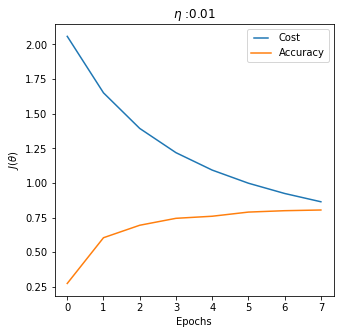

In [5]:
((X_train, y_train), (X_test, y_test)) = fashion_mnist.load_data()

# prendre moins d'images
X_train=X_train[0:200]
y_train=y_train[0:200]
X_test=X_test[0:10]
y_test=y_test[0:10]

print ("Learning on:", X_train.shape[0], " examples")
print ("Test on:",X_test.shape[0]," examples")

epochs = 8
eta = 0.01
network = MyCNN()
network.addLayer(Conv3x3(8))
network.addLayer(MaxPool2())
network.addLayer(Softmax(13 * 13 * 8, 10))
cost_history,accuracy_history=network.fit(X_train, y_train, verbose=True, epochs=epochs)

accuracy_test=[]
for i in range (len(X_test)):
    y_pred=network.predict(X_test[i])
    acc_test = network.accuracy(y_pred, y_test[i])
    accuracy_test.append(acc_test)
    
print("Accuracy test: %.3f"%np.average(accuracy_test))

# Affichage des historiques
plot_histories (eta,epochs,cost_history,accuracy_history)

## Comparaison avec Keras 

In [6]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train[0:520]
y_train=y_train[0:520]
x_test=x_test[0:280]
y_test=y_test[0:280]

print ("Learning on:", x_train.shape[0], " examples")
print ("Test on:",x_test.shape[0]," examples")

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Learning on: 520  examples
Test on: 280  examples
x_train shape: (520, 28, 28, 1)
520 train samples
280 test samples
Train on 520 samples, validate on 280 samples
Epoch 1/12
520/520 [==============================] - 0s 860us/step - loss: 2.1954 - accuracy: 0.2558 - val_loss: 2.0495 - val_accuracy: 0.3393
Epoch 2/12
520/520 [==============================] - 0s 363us/step - loss: 1.7746 - accuracy: 0.5538 - val_loss: 1.6218 - val_accuracy: 0.5857
Epoch 3/12
520/520 [==============================] - 0s 386us/step - loss: 1.2600 - accuracy: 0.7481 - val_loss: 1.2715 - val_accuracy: 0.6464
Epoch 4/12
520/520 [==============================] - 0s 361us/step - loss: 0.8651 - accuracy: 0.8365 - val_loss: 1.0892 - val_accuracy: 0.6929
Epoch 5/12
520/520 [==============================] - 0s 421us/step - loss: 0.6679 - accuracy: 0.8269 - val_loss: 0.7943 - val_accuracy: 0.7679
Epoch 6/12
520/520 [==============================] - 0s 384us/step - loss: 0.5297 - accuracy: 0.8673 - val_loss: 0.9